In [1]:
import pandas as pd
import openpyxl
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline

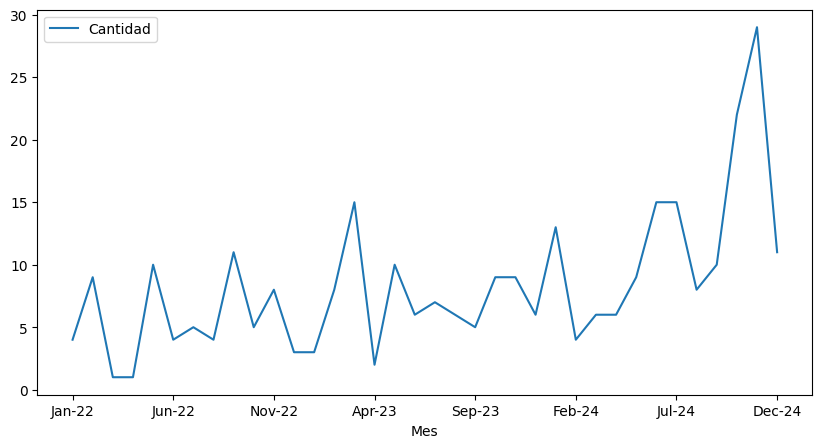

        Cantidad
Mes             
Jan-22         4
Feb-22         9
Mar-22         1
Apr-22         1
May-22        10
Jun-22         4
Jul-22         5
Aug-22         4
Sep-22        11
Oct-22         5
Nov-22         8
Dec-22         3
Jan-23         3
Feb-23         8
Mar-23        15
Apr-23         2
May-23        10
Jun-23         6
Jul-23         7
Aug-23         6
Sep-23         5
Oct-23         9
Nov-23         9
Dec-23         6
Jan-24        13
Feb-24         4
Mar-24         6
Apr-24         6
May-24         9
Jun-24        15
Jul-24        15
Aug-24         8
Sep-24        10
Oct-24        22
Nov-24        29
Dec-24        11


In [36]:
#base_ventas = pd.read_excel(r"/home/serway_85/ventasParasoles (2) (2).xlsm",sheet_name='ventas',index_col='Mes')
base_ventas = pd.read_excel(r"c:/Users/JORGE CONTRERAS/OneDrive - 900208659-2 DAMIS SAS/Escritorio/PLANEACION/consumos/INDICADORES PLANEACION/ventasParasoles (2) (2).xlsm",sheet_name='ventas',index_col='Mes')
#base_ventas['Mes']=base_ventas['Mes'].dt.strftime('%b-%y')
base_ventas_pergotek=base_ventas[(base_ventas['Familia']=='PERGOTEK') & (base_ventas['Tipo Factu']== 'PRODUCTO TERMINADO')]
total_nulos=base_ventas_pergotek.isnull().sum()
total_nulos

base_ventas

base_ventas.reset_index(inplace=True)
base_ventas['Mes'] = pd.to_datetime(base_ventas['Mes'], errors='coerce')

base_ventas.reset_index(inplace=True)
#base_ventas['Mes'] = pd.to_datetime(base_ventas['Mes'], errors='coerce')
#base_ventas['Mes'] = base_ventas['Mes'].dt.strftime('%b-%y')
base_ventas.set_index('Mes', inplace=True)
base_analisis=base_ventas[base_ventas['Familia']=='PERGOLITE']

base_analisis=base_analisis.groupby(['Mes'])['Cantidad'].sum().reset_index()
base_analisis = base_analisis.sort_values('Mes')
base_analisis['Mes'] = base_analisis['Mes'].dt.strftime('%b-%y')
base_analisis.set_index('Mes',inplace=True)



ventas=base_analisis['Cantidad']
base_analisis.plot(y='Cantidad',kind='line',figsize=(10,5))
plt.show()
print(base_analisis)



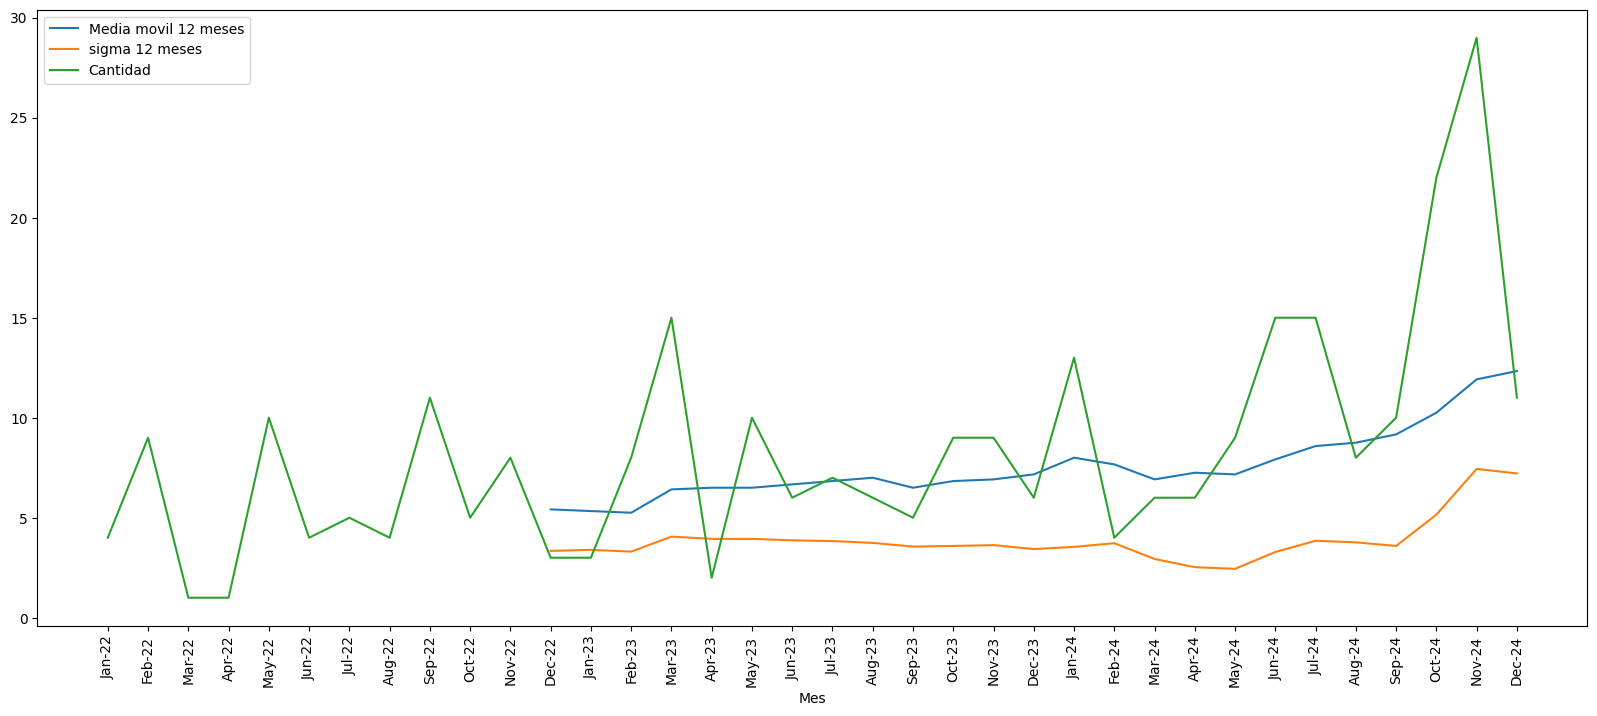

In [37]:
serietiempo = base_analisis['Cantidad']
type(serietiempo)
plt.figure(figsize=(20,8))
serietiempo.rolling(12).mean().plot(label= 'Media movil 12 meses')
serietiempo.rolling(12).std().plot(label= 'sigma 12 meses')
serietiempo.plot()
plt.xticks(rotation=90)  # Rotar los meses para que sean legibles
plt.xticks(ticks=range(len(base_analisis.index)), labels=base_analisis.index) 

plt.legend()


In [ ]:
#prueba de dickey-fuller aumentada

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
resultado = adfuller(base_analisis['Cantidad'])

resultado


(np.float64(1.8733452263693746),
 np.float64(0.9984839088686107),
 10,
 25,
 {'1%': np.float64(-3.7238633119999998),
  '5%': np.float64(-2.98648896),
  '10%': np.float64(-2.6328004)},
 np.float64(158.04281334104732))

In [40]:
#diferenciacion
base_analisis['Primera diferencia'] = base_analisis['Cantidad'] - base_analisis['Cantidad'].shift(1)

<Axes: xlabel='Mes'>

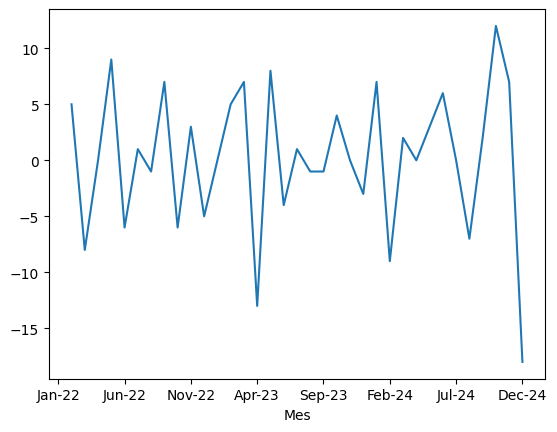

In [41]:
base_analisis['Primera diferencia'].plot()

In [42]:
adfuller(base_analisis['Primera diferencia'].dropna())

(np.float64(-6.906877921597723),
 np.float64(1.2407368346209195e-09),
 2,
 32,
 {'1%': np.float64(-3.653519805908203),
  '5%': np.float64(-2.9572185644531253),
  '10%': np.float64(-2.6175881640625)},
 np.float64(154.08523203562956))

In [43]:
base_analisis['Segunda diferencia'] = base_analisis['Primera diferencia'] - base_analisis['Primera diferencia'].shift(1)

<Axes: xlabel='Mes'>

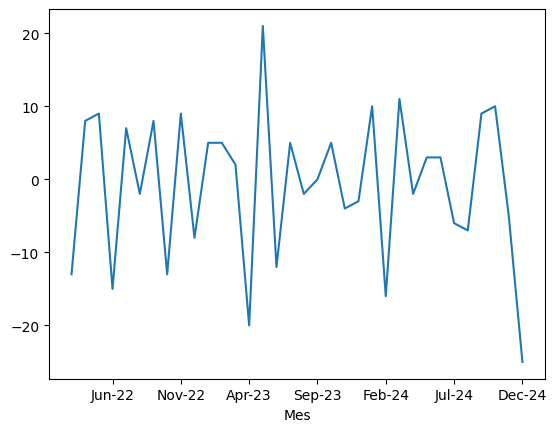

In [44]:
base_analisis['Segunda diferencia'].plot()

In [45]:
adfuller(base_analisis['Segunda diferencia'].dropna())

(np.float64(-4.048655900552555),
 np.float64(0.0011761053791724328),
 8,
 25,
 {'1%': np.float64(-3.7238633119999998),
  '5%': np.float64(-2.98648896),
  '10%': np.float64(-2.6328004)},
 np.float64(147.60173493464544))

In [46]:
#diferencia con estacionalidad
base_analisis['Diferencia Estacionalidad'] = base_analisis['Cantidad'] - base_analisis['Cantidad'].shift(12)

<Axes: xlabel='Mes'>

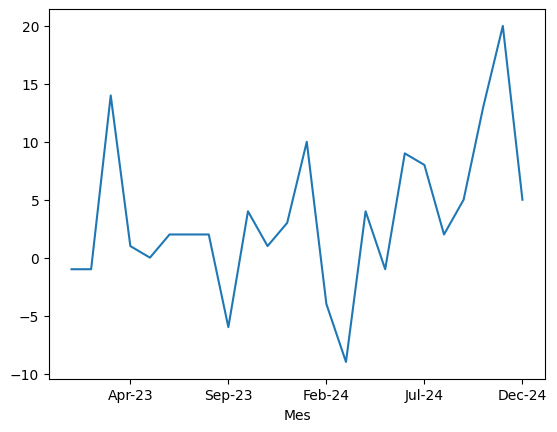

In [47]:
base_analisis['Diferencia Estacionalidad'].plot()

In [48]:
adfuller(base_analisis['Diferencia Estacionalidad'].dropna())

(np.float64(-3.77081251354669),
 np.float64(0.003220462871257336),
 0,
 23,
 {'1%': np.float64(-3.7529275211638033),
  '5%': np.float64(-2.998499866852963),
  '10%': np.float64(-2.6389669754253307)},
 np.float64(96.8401905252797))

In [49]:
base_analisis['Primera Diferencia Estacionalidad'] = base_analisis['Primera diferencia'] - base_analisis['Primera diferencia'].shift(12)

<Axes: xlabel='Mes'>

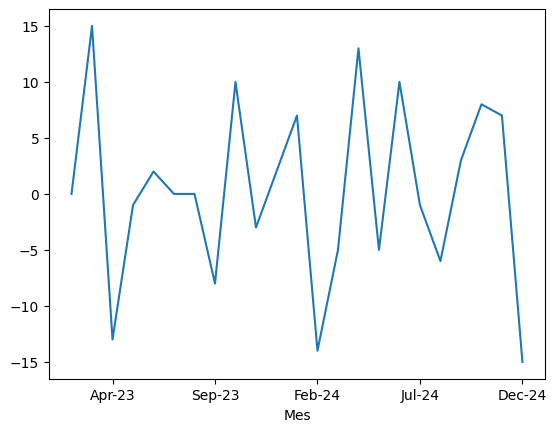

In [50]:
base_analisis['Primera Diferencia Estacionalidad'].plot()

In [51]:
adfuller(base_analisis['Primera Diferencia Estacionalidad'].dropna())

(np.float64(-0.30968866027794106),
 np.float64(0.9241208748749038),
 9,
 13,
 {'1%': np.float64(-4.068853732362312),
  '5%': np.float64(-3.1271488757396453),
  '10%': np.float64(-2.7017297633136095)},
 np.float64(92.69780875047985))

PARTIR LA BASE

<Axes: xlabel='Mes'>

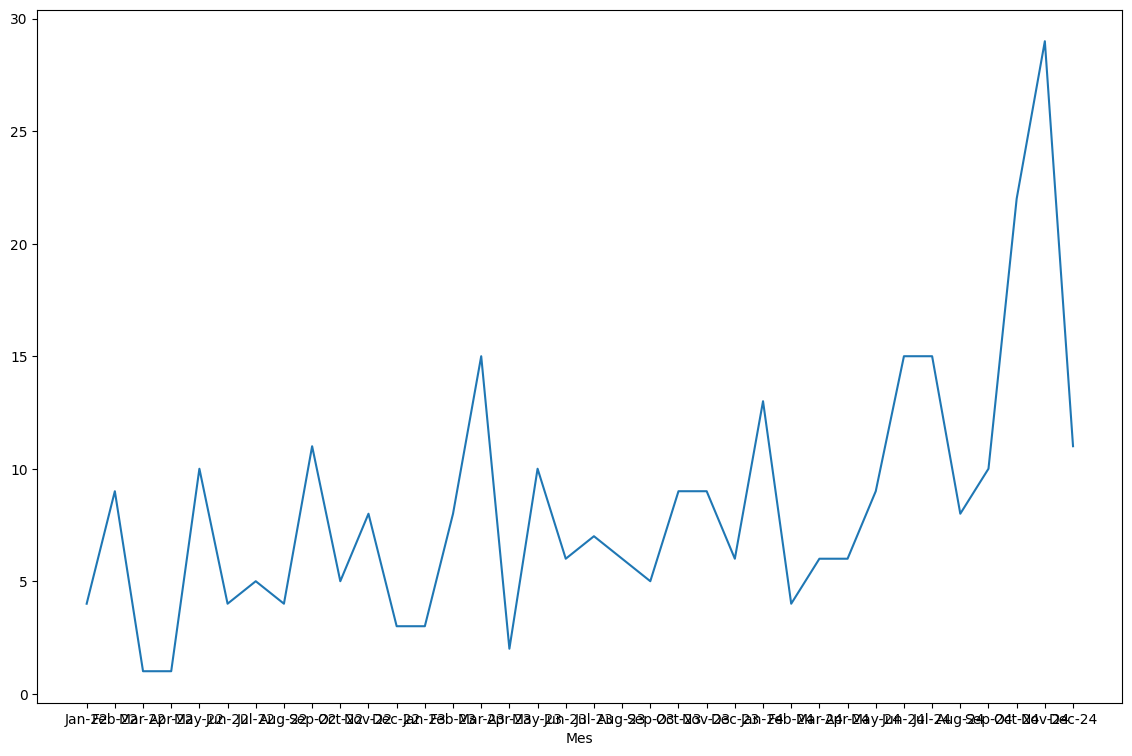

In [52]:
#partir la base en entrenamiento y prueba
plt.figure(figsize=(14,9))
plt.xticks(rotation=90)  # Rotar los meses para que sean legibles
plt.xticks(ticks=range(len(base_analisis.index)), labels=base_analisis.index) 
base_analisis['Cantidad'].plot()

In [53]:
BaseA = base_analisis[0:36]
BaseB = base_analisis[34:]
BaseA

,Cantidad,Primera diferencia,Segunda diferencia,Diferencia Estacionalidad,Primera Diferencia Estacionalidad
Mes,,,,,
Jan-22,4,NaN,NaN,NaN,NaN
Feb-22,9,5.0,NaN,NaN,NaN
Mar-22,1,-8.0,-13.0,NaN,NaN
Apr-22,1,0.0,8.0,NaN,NaN
May-22,10,9.0,9.0,NaN,NaN
Jun-22,4,-6.0,-15.0,NaN,NaN
Jul-22,5,1.0,7.0,NaN,NaN
Aug-22,4,-1.0,-2.0,NaN,NaN
Sep-22,11,7.0,8.0,NaN,NaN


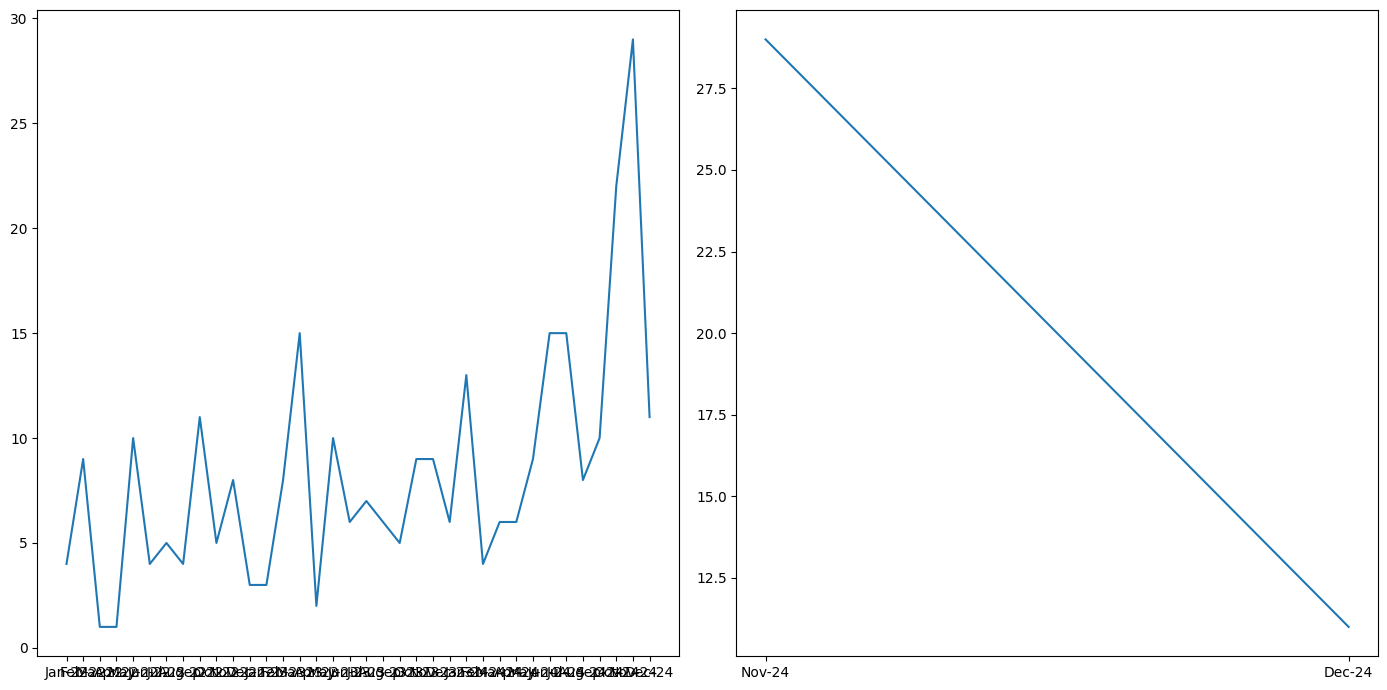

In [54]:

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(BaseA['Cantidad'],label='Ventas producto')


plt.subplot(1,2,2)
plt.plot(BaseB['Cantidad'],label='Ventas producto')


plt.tight_layout()



COMPONENTES ACF Y PACF

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

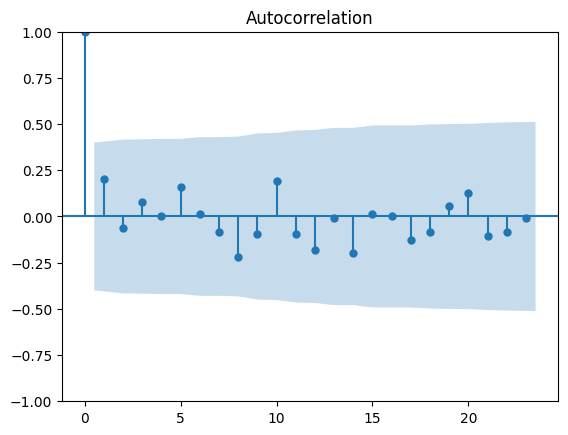

In [58]:
acf=plot_acf(BaseA['Diferencia Estacionalidad'].dropna(), lags=23)





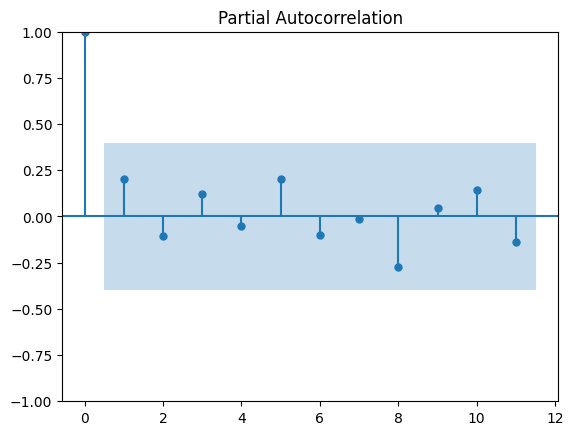

In [60]:
pacf=plot_pacf(BaseA['Diferencia Estacionalidad'].dropna(), lags=11)

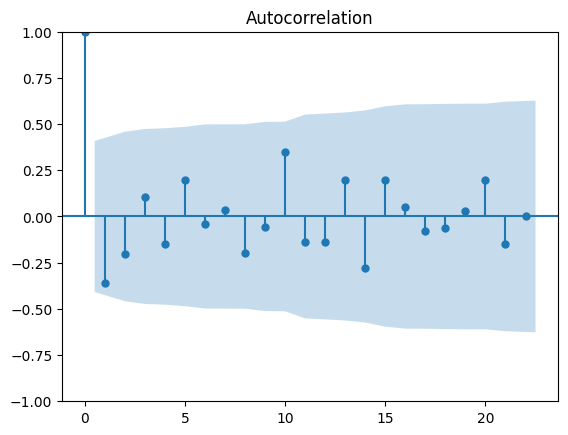

In [64]:
acf1=plot_acf(BaseA['Primera Diferencia Estacionalidad'].dropna(), lags=22)


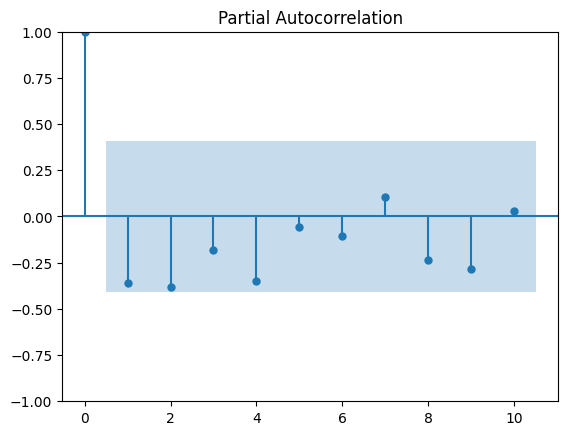

In [66]:
pacf1=plot_pacf(BaseA['Primera Diferencia Estacionalidad'].dropna(), lags=10)


In [67]:
from statsmodels.tsa.arima_model import  ARIMA

In [ ]:
modelo = sm.tsa.statespace.SARIMAX(BaseA['Cantidad'],order=(1,1,1),seasonal_order=(0,1,0,12))

c:\Users\JORGE CONTRERAS\proyecto_pronosticoV2\proyecto_damisV1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\JORGE CONTRERAS\proyecto_pronosticoV2\proyecto_damisV1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\JORGE CONTRERAS\proyecto_pronosticoV2\proyecto_damisV1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\User

In [68]:
resultados = modelo.fit()

In [70]:
print(resultados.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Cantidad   No. Observations:                   19
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                 -19.390
Date:                             Mon, 17 Feb 2025   AIC                             42.780
Time:                                     14:41:29   BIC                             42.363
Sample:                                          0   HQIC                            41.113
                                              - 19                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9948     60.736      0.016      0.987    -118.046     120.036
sigma2        27.2878   169

DatetimeIndex(['2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Mes', freq=None)


c:\Users\JORGE CONTRERAS\proyecto_pronosticoV2\proyecto_damisV1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\JORGE CONTRERAS\proyecto_pronosticoV2\proyecto_damisV1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JORGE CONTRERAS\AppData\Local\Temp\ipykernel_16216\472561219.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_futuras = pd.date_range(start=BaseA.index[-1] + pd.DateOffset(months=1),


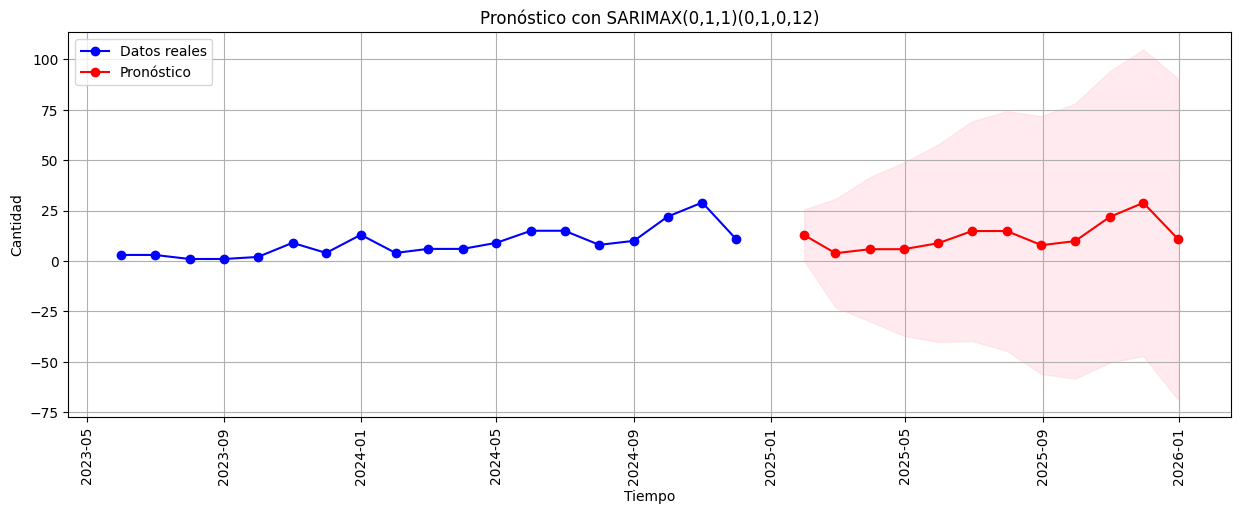

        Fecha  Pronóstico  Límite Inferior  Límite Superior
0  2025-01-31    12.85716         0.190146        25.524173
1  2025-02-28     3.85716       -23.013644        30.727963
2  2025-03-31     5.85716       -29.970581        41.684900
3  2025-04-30     5.85716       -37.098793        48.813112
4  2025-05-31     8.85716       -40.201995        57.916315
5  2025-06-30    14.85716       -39.625751        69.340070
6  2025-07-31    14.85716       -44.556428        74.270748
7  2025-08-31     7.85716       -56.108154        71.822473
8  2025-09-30     9.85716       -58.356828        78.071148
9  2025-10-31    21.85716       -50.355963        94.070282
10 2025-11-30    28.85716       -47.144958       104.859277
11 2025-12-31    10.85716       -68.753824        90.468144


In [35]:
print(BaseA.index)


# 1️⃣ Crear el modelo SARIMAX
modelo_final = sm.tsa.statespace.SARIMAX(BaseA['Cantidad'],
                                         order=(0,1,1), 
                                         seasonal_order=(0,1,0,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

resultado = modelo_final.fit()

# 2️⃣ Hacer predicciones para los próximos 12 meses
periodos_prediccion = 12
predicciones = resultado.get_forecast(steps=periodos_prediccion)
intervalo_confianza = predicciones.conf_int()

# 3️⃣ Generar las fechas futuras para el eje X
BaseA.index = pd.to_datetime(BaseA.index, format='%b-%y')

if pd.isnull(BaseA.index[-1]):
    print("Error: Última fecha en BaseA no es válida")
else:
    fechas_futuras = pd.date_range(start=BaseA.index[-1] + pd.DateOffset(months=1), 
                                   periods=periodos_prediccion, freq='M')

# 4️⃣ Graficar los resultados
plt.figure(figsize=(15,5))
plt.plot(BaseA.index, BaseA['Cantidad'], label='Datos reales', color='blue', marker='o')
plt.plot(fechas_futuras, predicciones.predicted_mean, label='Pronóstico', color='red', marker='o')

# 5️⃣ Agregar etiquetas de valores en los puntos de pronóstico
# Asegurar que predicciones tengan las fechas correctas
predicciones_df = pd.DataFrame({'Prediccion': predicciones.predicted_mean}, index=fechas_futuras)

for i, (fecha, txt) in enumerate(predicciones_df.itertuples()):
    plt.annotate(f"{txt:.1f}", (fecha, txt), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='red')


# 6️⃣ Agregar banda de intervalo de confianza
plt.fill_between(fechas_futuras, 
                 intervalo_confianza.iloc[:, 0], 
                 intervalo_confianza.iloc[:, 1], 
                 color='pink', alpha=0.3)

# 7️⃣ Personalizar la visualización
plt.xticks(rotation=90)  # Rotar etiquetas del eje X
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.title('Pronóstico con SARIMAX(0,1,1)(0,1,0,12)')
plt.legend()
plt.grid()

# 8️⃣ Mostrar la gráfica
plt.show()

tabla_pronostico = pd.DataFrame({
    'Fecha': fechas_futuras,  # Fechas futuras
    'Pronóstico': predicciones.predicted_mean.values,  # Valores pronosticados
    'Límite Inferior': intervalo_confianza.iloc[:, 0].values,  # Intervalo inferior
    'Límite Superior': intervalo_confianza.iloc[:, 1].values   # Intervalo superior
})

# Mostrar la tabla en pantalla
print(tabla_pronostico)

# Opcional: Guardar la tabla en un archivo CSV
tabla_pronostico.to_csv('pro', index=False)
